In [92]:
# Bloque 1: Importar librerías
import yfinance as yf
import pandas as pd
import ta

In [93]:
def get_stock_data(ticker, period,interval):
    data = yf.download(ticker, period= period, interval=interval)
    data.columns = data.columns.droplevel(1)
    return data

ticker = "AMD"
period = "180d"  # Últimos 60 días
interval = "1h"  # Datos por hora

data = get_stock_data(ticker,period,interval)

# Convertir el índice a columna
data.reset_index(inplace=True)

# Renombrar la columna si es necesario (por defecto se llamará "index")
data.rename(columns={'Datetime': 'Date'}, inplace=True)

# Convertir la columna 'Date' a formato datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Day'] = data['Date'].dt.day
data['Month'] = data['Date'].dt.month
data['Hour'] = data['Date'].dt.hour
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,Day,Month,Hour
0,2024-06-26 13:30:00+00:00,158.399902,160.740005,158.260101,160.520004,8385961,26,6,13
1,2024-06-26 14:30:00+00:00,156.910004,158.910004,156.750000,158.360001,6548424,26,6,14
2,2024-06-26 15:30:00+00:00,157.255005,157.820007,156.535004,156.899994,4556013,26,6,15
3,2024-06-26 16:30:00+00:00,157.102798,157.399994,156.020004,157.229996,3877517,26,6,16
4,2024-06-26 17:30:00+00:00,156.779999,157.240005,156.460007,157.080002,2706267,26,6,17


In [94]:
def calculate_indicators(data):
    # ===================== 📌 MEDIAS MÓVILES =====================
    data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()

    # ===================== 🔥 BOLLINGER BANDS =====================
    data['BB_upper'] = data['Close'].rolling(window=20).mean() + 2 * data['Close'].rolling(window=20).std()
    data['BB_lower'] = data['Close'].rolling(window=20).mean() - 2 * data['Close'].rolling(window=20).std()
    data['BBW'] = (data['BB_upper'] - data['BB_lower']) / data['Close']  # Ancho de BB

    # ===================== 📊 VOLUMEN =====================
    data['Volume_MA'] = data['Volume'].rolling(window=20).mean()
    data['Vol_Ratio_10h'] = data['Volume'] / data['Volume'].rolling(window=10).mean()

    # ===================== 🔄 CAMBIOS PORCENTUALES =====================
    data['Hourly_Return'] = data['Close'].pct_change() * 100
    data['Cumulative_Return'] = data['Close'].pct_change(periods=5) * 100  # Cambio acumulado en 5 horas

    # ===================== 📈 MACD =====================
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # ===================== 📊 RSI =====================
    data['RSI'] = ta.momentum.rsi(data['Close'], window=14)

    # ===================== 📉 ATR =====================
    data['ATR'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=14)

    # ===================== 📊 ADX (Índice de Dirección Media) =====================
    data['ADX'] = ta.trend.adx(data['High'], data['Low'], data['Close'], window=14)

    # ===================== 🔄 ESTOCÁSTICO =====================
    data['Stoch_K'] = ta.momentum.stoch(data['High'], data['Low'], data['Close'], window=14, smooth_window=3)
    data['Stoch_D'] = ta.momentum.stoch_signal(data['High'], data['Low'], data['Close'], window=14, smooth_window=3)

    # ===================== 🔥 MOMENTUM =====================
    data['MOM'] = ta.momentum.roc(data['Close'], window=10)

    # ===================== 🔎 OBV (On-Balance Volume) =====================
    data['OBV'] = ta.volume.on_balance_volume(data['Close'], data['Volume'])

    # ===================== 💰 CMF (Chaikin Money Flow) =====================
    data['CMF'] = ta.volume.chaikin_money_flow(data['High'], data['Low'], data['Close'], data['Volume'], window=20)

    # Eliminar filas con NaN generadas por indicadores
    data.dropna(inplace=True)

    return data

# Aplicar la función al dataframe
data = calculate_indicators(data)

# Mostrar primeras filas con indicadores
print(data.head())


Price                      Date       Close        High         Low  \
49    2024-07-08 17:30:00+00:00  177.809998  178.130997  176.250000   
50    2024-07-08 18:30:00+00:00  177.190002  177.839996  176.869995   
51    2024-07-08 19:30:00+00:00  178.660004  178.949997  177.160004   
52    2024-07-09 13:30:00+00:00  175.576904  180.410004  175.510300   
53    2024-07-09 14:30:00+00:00  175.990005  177.209595  174.699997   

Price        Open    Volume  Day  Month  Hour       EMA12  ...      MACD  \
49     176.529999   7190578    8      7    17  172.922288  ...  4.202704   
50     177.820007   4712479    8      7    18  173.578860  ...  4.231837   
51     177.190002   5881320    8      7    19  174.360574  ...  4.323701   
52     177.960007  17170901    9      7    13  174.547702  ...  4.100456   
53     175.574997   8203295    9      7    14  174.769595  ...  3.911774   

Price  MACD_Signal        RSI       ATR        ADX    Stoch_K    Stoch_D  \
49        3.554949  78.446505  2.293722 

In [95]:
import numpy as np

# ===================== 📌 CAMBIO PORCENTUAL PASADO =====================
data['Past_Change_1w'] = (data['Close'] - data['Close'].shift(35)) / data['Close'].shift(35) * 100
data['Past_Change_2w'] = (data['Close'] - data['Close'].shift(70)) / data['Close'].shift(70) * 100
data['Past_Change_1m'] = (data['Close'] - data['Close'].shift(140)) / data['Close'].shift(140) * 100

# ===================== 📌 CAMBIO PORCENTUAL FUTURO (2 SEMANAS) =====================
data['Future_Change_2w'] = (data['Close'].shift(-70) - data['Close']) / data['Close'] * 100

# ===================== 📌 FUNCIÓN PARA CLASIFICAR CAMBIOS =====================
def classify_change(percentage, percentiles):
    if percentage <= percentiles[0]:
        return 0  # Venta Muy Fuerte
    elif percentage <= percentiles[1]:
        return 1  # Venta
    elif percentage <= percentiles[2]:
        return 2  # Neutral
    elif percentage <= percentiles[3]:
        return 3  # Compra
    else:
        return 4  # Compra Muy Fuerte

# ===================== 📌 CALCULAR PERCENTILES DINÁMICOS =====================
percentiles_1w = np.percentile(data['Past_Change_1w'].dropna(), [15, 40, 60, 85])
percentiles_2w = np.percentile(data['Past_Change_2w'].dropna(), [15, 40, 60, 85])
percentiles_1m = np.percentile(data['Past_Change_1m'].dropna(), [15, 40, 60, 85])
percentiles_future_2w = np.percentile(data['Future_Change_2w'].dropna(), [15, 40, 60, 85])

# ===================== 📌 APLICAR CLASIFICACIÓN =====================
data['Past_Class_1w'] = data['Past_Change_1w'].apply(lambda x: classify_change(x, percentiles_1w))
data['Past_Class_2w'] = data['Past_Change_2w'].apply(lambda x: classify_change(x, percentiles_2w))
data['Past_Class_1m'] = data['Past_Change_1m'].apply(lambda x: classify_change(x, percentiles_1m))
data['Future_Class_2w'] = data['Future_Change_2w'].apply(lambda x: classify_change(x, percentiles_future_2w))

# ===================== 📌 MOSTRAR RESULTADOS =====================
print("Percentiles de cambios pasados (2 semanas):", percentiles_2w)
print("Percentiles de cambios futuros (2 semanas):", percentiles_future_2w)

# Mostrar las primeras filas
print(data[['Date', 'Close', 'Past_Change_2w', 'Past_Class_2w', 'Future_Change_2w', 'Future_Class_2w']].head(20))


Percentiles de cambios pasados (2 semanas): [-11.03615594  -5.19747364  -2.19449898   6.35430445]
Percentiles de cambios futuros (2 semanas): [-11.03615594  -5.19747364  -2.19449898   6.35430445]
Price                      Date       Close  Past_Change_2w  Past_Class_2w  \
49    2024-07-08 17:30:00+00:00  177.809998             NaN              4   
50    2024-07-08 18:30:00+00:00  177.190002             NaN              4   
51    2024-07-08 19:30:00+00:00  178.660004             NaN              4   
52    2024-07-09 13:30:00+00:00  175.576904             NaN              4   
53    2024-07-09 14:30:00+00:00  175.990005             NaN              4   
54    2024-07-09 15:30:00+00:00  176.987106             NaN              4   
55    2024-07-09 16:30:00+00:00  175.129593             NaN              4   
56    2024-07-09 17:30:00+00:00  176.179993             NaN              4   
57    2024-07-09 18:30:00+00:00  176.690002             NaN              4   
58    2024-07-09 19:30:0

In [96]:
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Day', 'Month',
       'Hour', 'EMA12', 'EMA26', 'EMA50', 'SMA50', 'BB_upper', 'BB_lower',
       'BBW', 'Volume_MA', 'Vol_Ratio_10h', 'Hourly_Return',
       'Cumulative_Return', 'MACD', 'MACD_Signal', 'RSI', 'ATR', 'ADX',
       'Stoch_K', 'Stoch_D', 'MOM', 'OBV', 'CMF', 'Past_Change_1w',
       'Past_Change_2w', 'Past_Change_1m', 'Future_Change_2w', 'Past_Class_1w',
       'Past_Class_2w', 'Past_Class_1m', 'Future_Class_2w'],
      dtype='object', name='Price')

In [97]:
data = data.drop(columns=['Cumulative_Return','Stoch_K','Stoch_D','ADX','CMF', 'EMA50', 'SMA50','Volume_MA',
                          'Vol_Ratio_10h', 'Hourly_Return','Volume','Month','Hour',]) ## Aquí se hacen las pruebas 

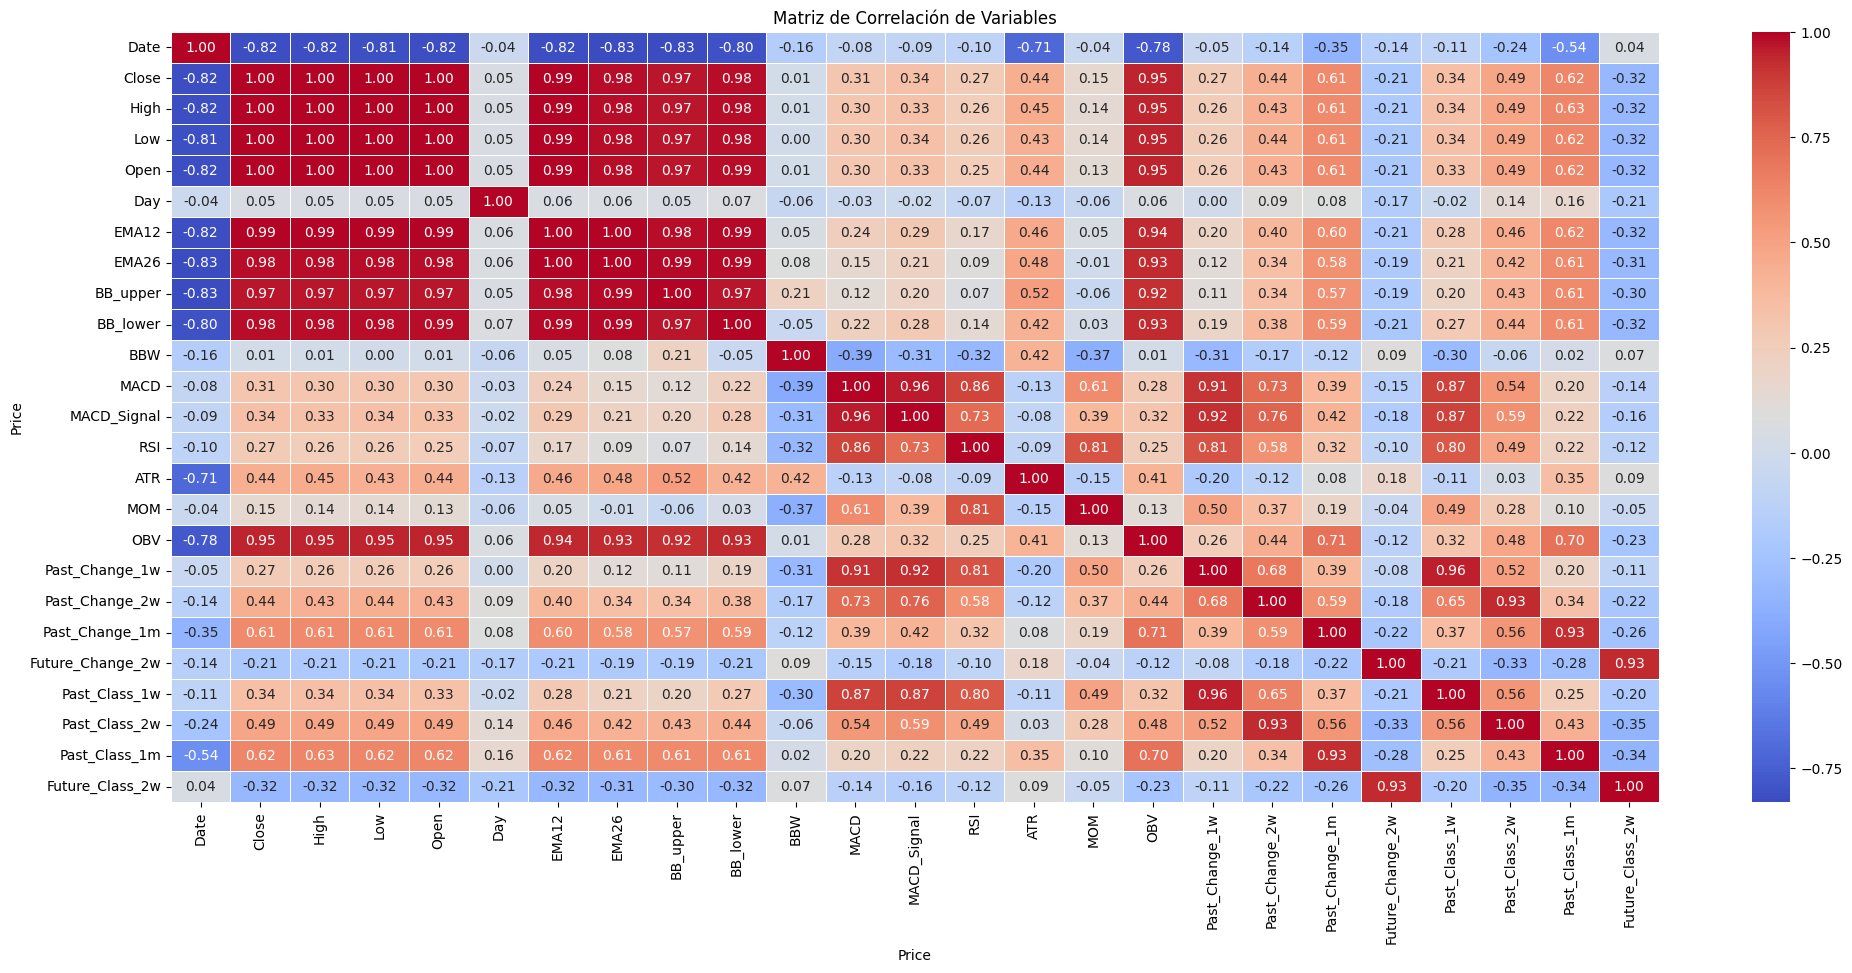

Price
Future_Class_2w     1.000000
Future_Change_2w    0.934565
ATR                 0.088155
BBW                 0.071205
Date                0.042342
MOM                -0.046763
Past_Change_1w     -0.106505
RSI                -0.117411
MACD               -0.135800
MACD_Signal        -0.164216
Past_Class_1w      -0.204263
Day                -0.208449
Past_Change_2w     -0.223769
OBV                -0.234832
Past_Change_1m     -0.255841
BB_upper           -0.301694
EMA26              -0.309797
High               -0.315768
EMA12              -0.316505
Close              -0.317428
Open               -0.317843
Low                -0.320105
BB_lower           -0.321030
Past_Class_1m      -0.341305
Past_Class_2w      -0.349991
Name: Future_Class_2w, dtype: float64


In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = data.corr()

# Configurar la figura
plt.figure(figsize=(24, 10))

# Crear un heatmap con Seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título del gráfico
plt.title("Matriz de Correlación de Variables")

# Mostrar la gráfica
plt.show()
print(correlation_matrix['Future_Class_2w'].sort_values(ascending=False)) 

In [108]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report

# Eliminar valores nulos
data_train = data.dropna()

print(data_train['Future_Class_2w'].value_counts())

# Preparar los datos
X = data_train.drop(columns=['Future_Change_2w', 'Future_Class_2w', 'Date'])  # Características (todas las columnas menos la columna objetivo)
y = data_train['Future_Class_2w']  # Columna objetivo

# Normalización de las características usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)  # Aplicamos el escalado a las características

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Inicializar los modelos
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=500,  # Más árboles para estabilidad
        max_depth=10,  # Evitar sobreajuste
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1  # Paralelización
    ),

    'XGBoost': xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_estimators=500,  # Más iteraciones
        learning_rate=0.01,  # Más bajo para estabilidad
        max_depth=6,  # Controla sobreajuste
        subsample=0.8,  # Evita overfitting
        colsample_bytree=0.8,
        gamma=0.1,  # Reduce falsos positivos
        min_child_weight=5,  # Evita divisiones poco útiles
        random_state=42,
        n_jobs=-1
    ),

    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=500,
        learning_rate=0.01,  # Baja tasa para estabilidad
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,  # Evitar overfitting
        random_state=42
    ),

    'LightGBM': lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=-1,  # Sin límite de profundidad
        num_leaves=31,  # Más hojas, mejor generalización
        min_child_samples=20,  # Evita overfitting
        subsample=0.8,
        colsample_bytree=0.8,
        force_col_wise=True,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
}


Future_Class_2w
3    268
1    265
2    203
4    153
0     94
Name: count, dtype: int64


In [109]:
# Entrenar y evaluar cada modelo
predictions = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Entrenar el modelo
    y_pred = model.predict(X_test)  # Predecir sobre el conjunto de prueba
    predictions[model_name] = y_pred

# Mostrar las métricas para cada modelo
model_metrics = {}
for model_name, y_pred in predictions.items():
    report = classification_report(y_test, y_pred, output_dict=True)
    model_metrics[model_name] = report

# model_metrics

In [101]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

# Evaluar modelos con Accuracy, F1-score y Kappa
model_scores = {}

for model_name, y_pred in predictions.items():
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # F1 ponderado
    kappa = cohen_kappa_score(y_test, y_pred)  # Cohen's Kappa

    model_scores[model_name] = {'accuracy': accuracy, 'f1_score': f1, 'kappa': kappa}

# Ordenar modelos por precisión (puedes cambiar a 'f1_score' o 'kappa' si prefieres)
sorted_models = sorted(model_scores.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Imprimir los 3 mejores modelos
print("🔹 Top 3 Modelos Basados en Precisión:")
for i, (model_name, scores) in enumerate(sorted_models[:3]):
    print(f"{i + 1}. {model_name} - Precisión: {scores['accuracy']:.4f} | F1-Score: {scores['f1_score']:.4f} | Kappa: {scores['kappa']:.4f}")


🔹 Top 3 Modelos Basados en Precisión:
1. Gradient Boosting - Precisión: 0.8475 | F1-Score: 0.8461 | Kappa: 0.8033
2. XGBoost - Precisión: 0.8441 | F1-Score: 0.8440 | Kappa: 0.7984
3. LightGBM - Precisión: 0.8373 | F1-Score: 0.8356 | Kappa: 0.7898


In [102]:
# Mostrar la cantidad de cada predicción por modelo
prediction_counts = {}

for model_name, y_pred in predictions.items():
    unique, counts = np.unique(y_pred, return_counts=True)  # Contar la frecuencia de cada predicción
    prediction_counts[model_name] = dict(zip(unique, counts))


In [103]:
# Crear un DataFrame para almacenar las predicciones y los valores reales
comparison_df = {}

for model_name, y_pred in predictions.items():
    # Crear un DataFrame con las predicciones y las clases reales
    comparison_df[model_name] = pd.DataFrame({
        'Real': y_test,  # Valores reales
        'Predicción': y_pred  # Predicciones del modelo
    })

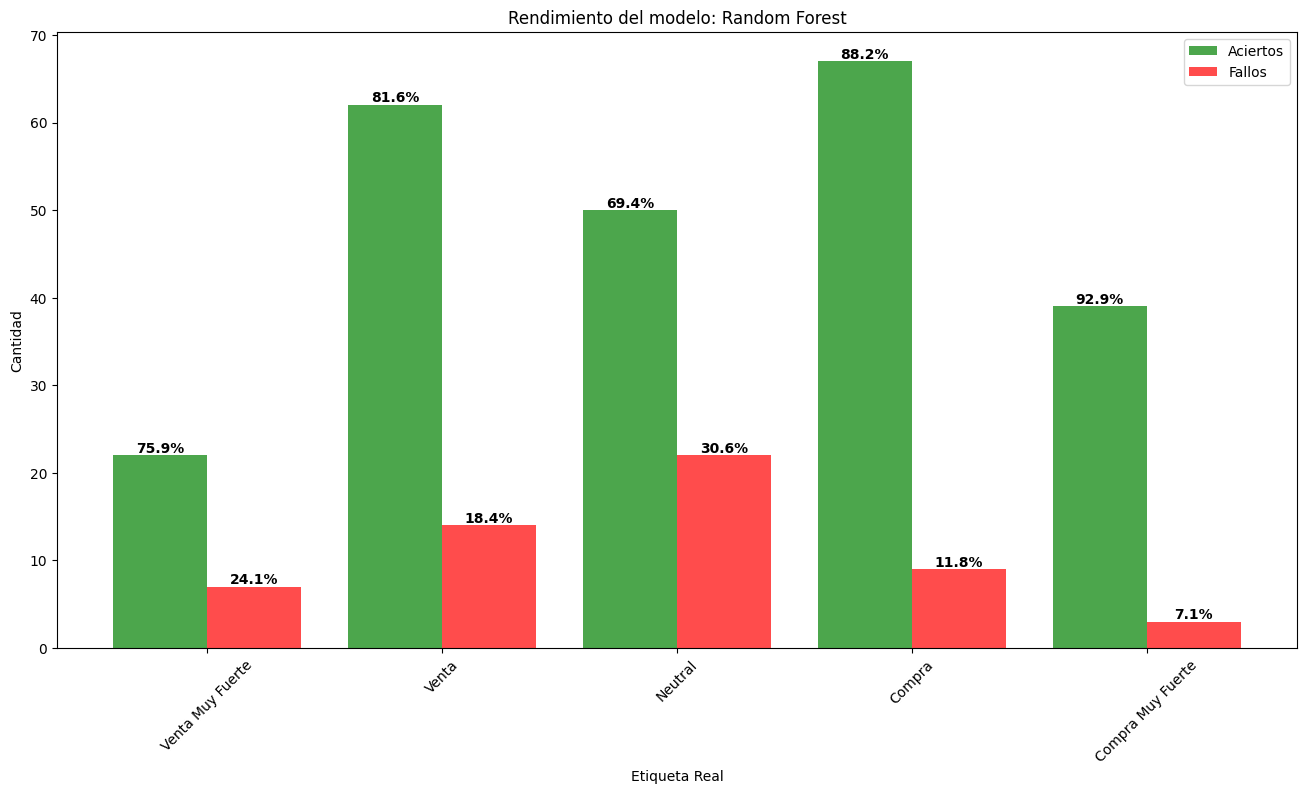

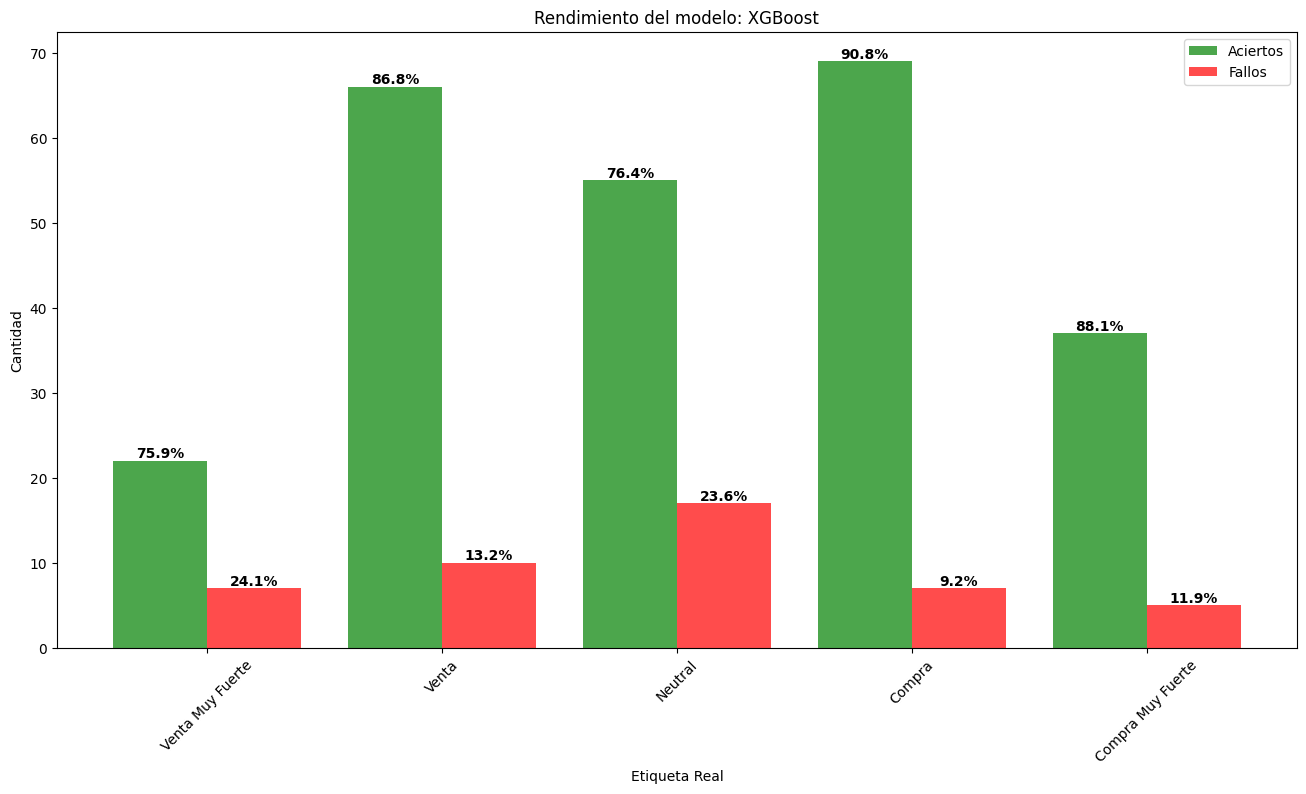

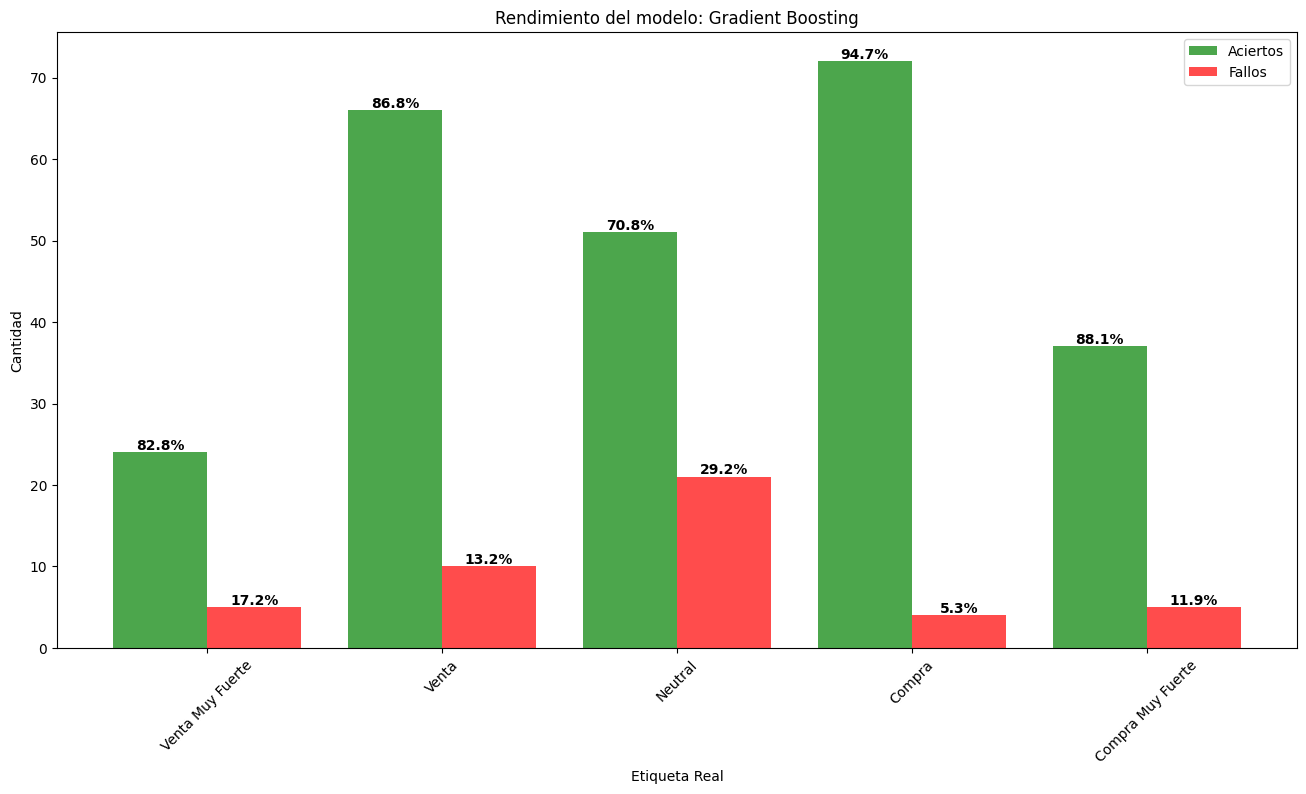

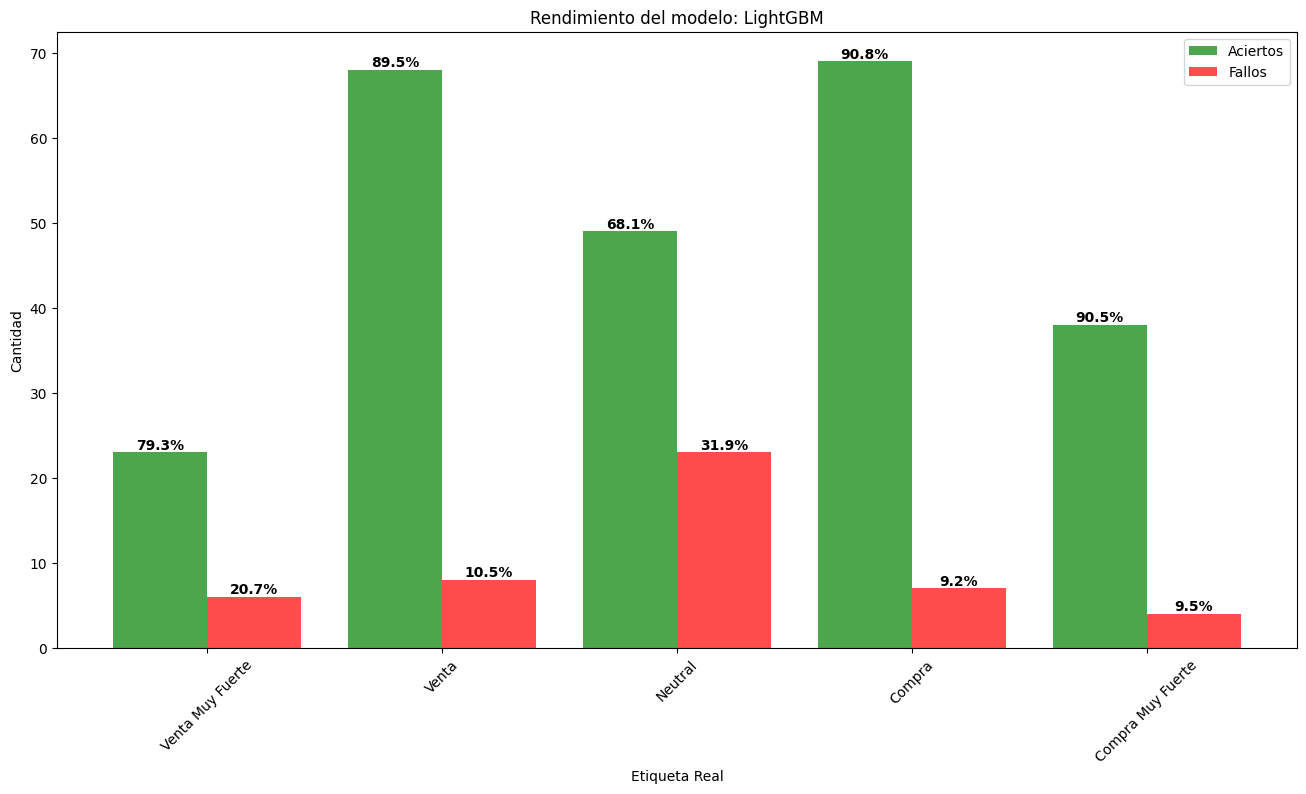

In [104]:
# 🔹 Diccionario para mapear números a etiquetas (con orden específico)
label_mapping = {
    0: 'Venta Muy Fuerte',
    1: 'Venta',
    2: 'Neutral',
    3: 'Compra',
    4: 'Compra Muy Fuerte',
}

# Lista ordenada de etiquetas
ordered_labels = list(label_mapping.values())

# 🔹 Crear un DataFrame para almacenar las comparaciones
comparison_df = {}

for model_name, y_pred in predictions.items():
    # Crear DataFrame con valores reales y predicciones
    df = pd.DataFrame({
        'Real': y_test, 
        'Predicción': y_pred
    })
    
    # Convertir los valores numéricos a etiquetas de texto
    df['Real'] = df['Real'].map(label_mapping)
    df['Predicción'] = df['Predicción'].map(label_mapping)

    # Definir el orden de las categorías para "Real" y "Predicción"
    df['Real'] = pd.Categorical(df['Real'], categories=ordered_labels, ordered=True)
    df['Predicción'] = pd.Categorical(df['Predicción'], categories=ordered_labels, ordered=True)

    # Guardar en el diccionario
    comparison_df[model_name] = df

# 🔹 Crear una gráfica para comparar aciertos y errores por cada etiqueta
for model_name, df in comparison_df.items():
    df['Correcto'] = df['Real'] == df['Predicción']  # True si acertó, False si falló

    # Contar aciertos y errores por etiqueta
    results = df.groupby(['Real', 'Correcto'], observed=False).size().unstack(fill_value=0)

    # Asegurar que las columnas existen y renombrarlas si es necesario
    results = results.rename(columns={True: 'Aciertos', False: 'Fallos'})

    # Si faltan columnas, agregarlas con 0
    results = results.reindex(columns=['Aciertos', 'Fallos'], fill_value=0)

    # Calcular porcentajes
    total_counts = results.sum(axis=1)
    percentages = results.div(total_counts, axis=0) * 100  # Convertir a porcentaje

    # 🔹 Gráfica con barras separadas (verde a la izquierda, roja a la derecha)
    x = np.arange(len(ordered_labels))  # Posiciones de las etiquetas
    width = 0.4  # Ancho de las barras

    plt.figure(figsize=(16, 8))
    
    # Barras de aciertos (izquierda)
    bars1 = plt.bar(x - width/2, results['Aciertos'], width=width, color='green', alpha=0.7, label='Aciertos')

    # Barras de fallos (derecha)
    bars2 = plt.bar(x + width/2, results['Fallos'], width=width, color='red', alpha=0.7, label='Fallos')

    # 🔹 Añadir los porcentajes sobre cada barra
    for bar, pct1 in zip(bars1, percentages['Aciertos']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct1:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    for bar, pct2 in zip(bars2, percentages['Fallos']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{pct2:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # 🔹 Formato final de la gráfica
    plt.title(f'Rendimiento del modelo: {model_name}')
    plt.xlabel('Etiqueta Real')
    plt.ylabel('Cantidad')
    plt.xticks(x, ordered_labels, rotation=45)  # Etiquetas con rotación
    plt.legend()
    plt.show()

In [105]:
# Obtener los datos de ayer (última fila)
yesterday_data = data.iloc[-1:]

# Extraer fecha y precio de cierre de ayer
yesterday_date = yesterday_data['Date'].values[0]  
yesterday_close = yesterday_data['Close'].values[0]  

# Asegurar que no incluimos variables de futuro
X_yesterday = yesterday_data.drop(columns=['Future_Change_2w', 'Future_Class_2w', 'Date'])
X_yesterday_np = X_yesterday.to_numpy()  # Convertir a numpy para evitar warnings de Scikit-Learn

# Hacer predicciones con cada modelo
future_predictions = {}

for model_name, model in models.items():
    future_prediction = model.predict(X_yesterday_np)[0]  # Obtener la predicción numérica
    
    future_predictions[model_name] = (
        f"📉 Caída muy fuerte (< {percentiles_future_2w[0]:.2f}%)" if future_prediction == 0 else
        f"🔻 Caída moderada ({percentiles_future_2w[0]:.2f}% a {percentiles_future_2w[1]:.2f}%)" if future_prediction == 1 else
        f"➖ Sin cambios significativos ({percentiles_future_2w[1]:.2f}% a {percentiles_future_2w[2]:.2f}%)" if future_prediction == 2 else
        f"🔼 Subida moderada ({percentiles_future_2w[2]:.2f}% a {percentiles_future_2w[3]:.2f}%)" if future_prediction == 3 else
        f"🚀 Subida muy fuerte (> {percentiles_future_2w[3]:.2f}%)"
    )

# Mostrar los resultados con fecha formateada correctamente
print(f"\n📅 Fecha de la última observación: {pd.to_datetime(yesterday_date).strftime('%Y-%m-%d %H:%M')}")
print(f"💰 Precio de cierre: {yesterday_close:.2f} USD\n")

print("🔮 Predicciones de 'Future_Class_2w' para los datos de ayer:")
for model_name, prediction in future_predictions.items():
    print(f"⚡ {model_name}: {prediction}")


[LightGBM] [Warning] Unknown parameter: silent

📅 Fecha de la última observación: 2025-03-14 13:30
💰 Precio de cierre: 100.18 USD

🔮 Predicciones de 'Future_Class_2w' para los datos de ayer:
⚡ Random Forest: 🔻 Caída moderada (-11.04% a -5.20%)
⚡ XGBoost: 🔻 Caída moderada (-11.04% a -5.20%)
⚡ Gradient Boosting: 🚀 Subida muy fuerte (> 6.35%)
⚡ LightGBM: 🔻 Caída moderada (-11.04% a -5.20%)


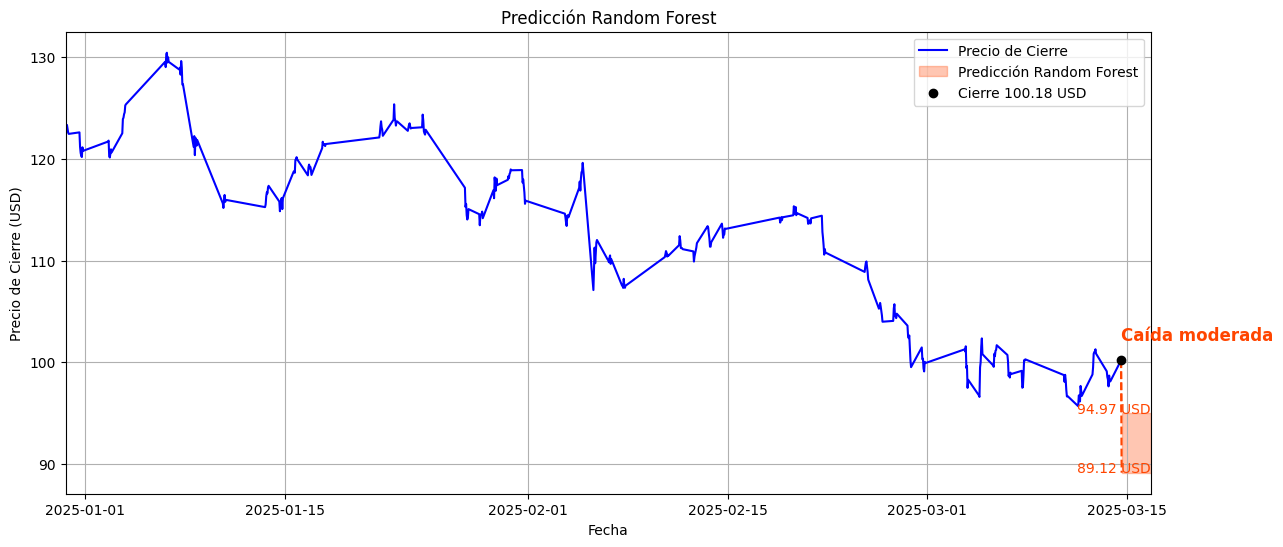

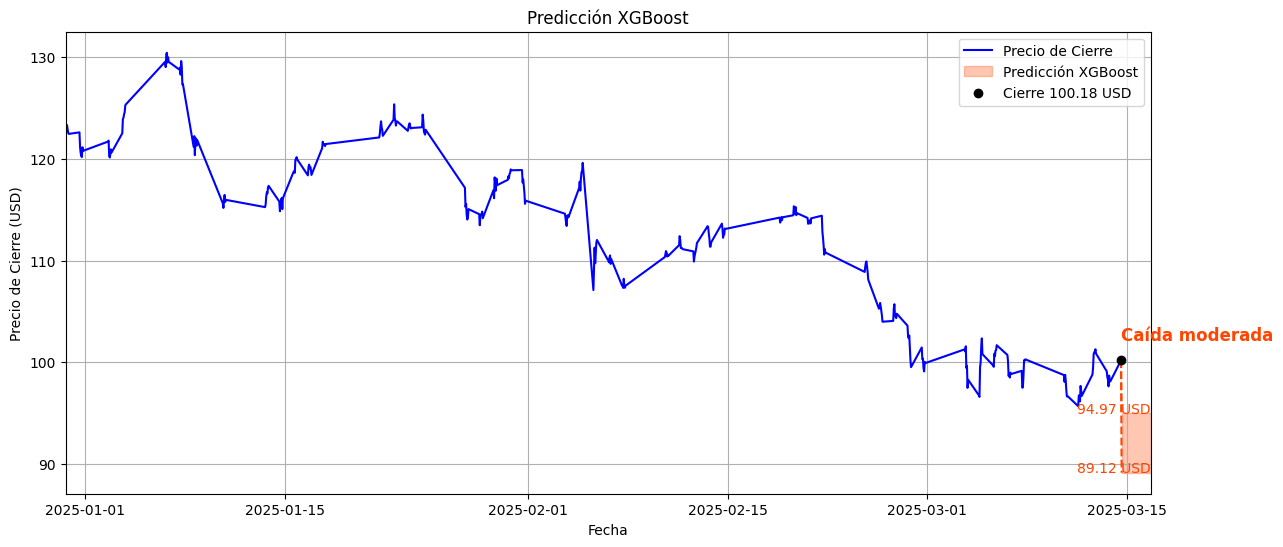

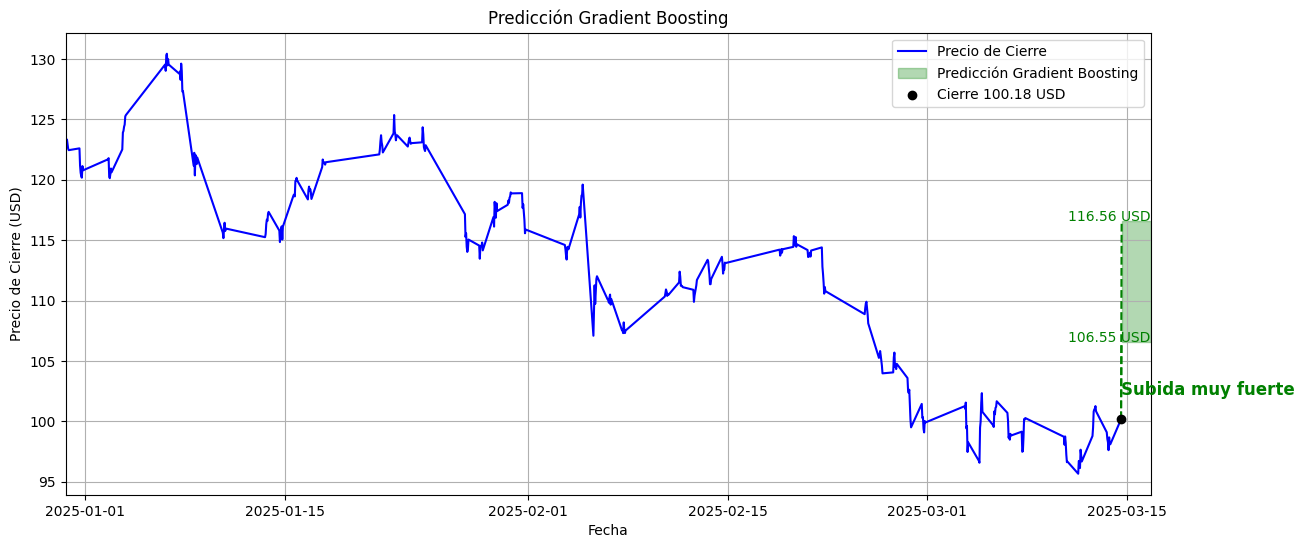

[LightGBM] [Warning] Unknown parameter: silent


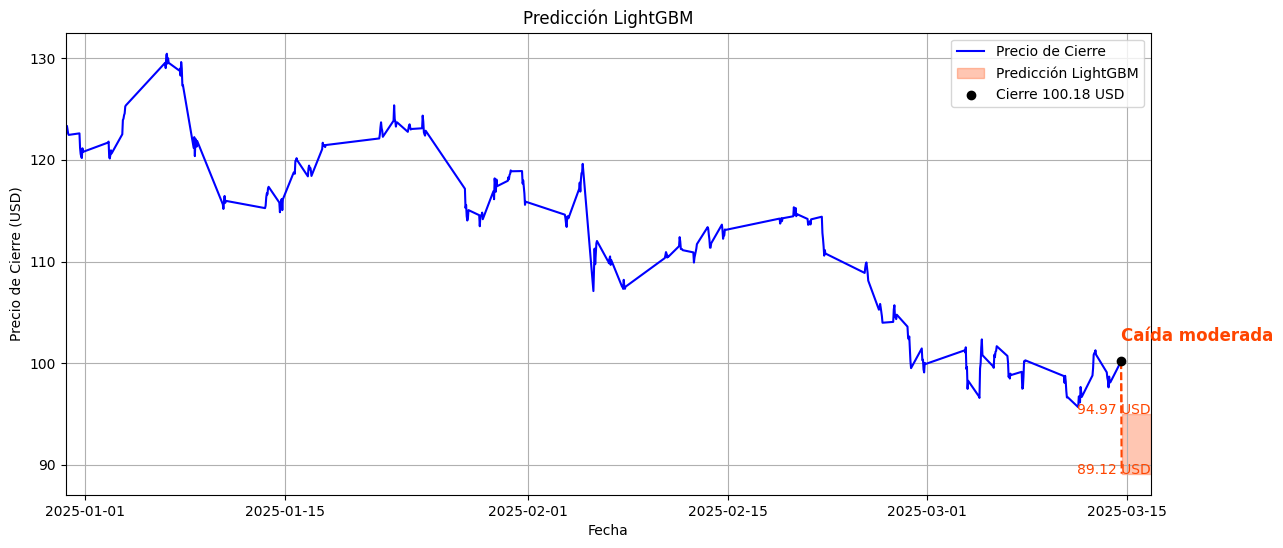

In [106]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Últimos 350 registros para graficar historial
data_last_350 = data.tail(350)

# Obtener datos de ayer (última fila)
yesterday_data = data.iloc[-1:]
yesterday_date = yesterday_data['Date'].values[0]
yesterday_close = yesterday_data['Close'].values[0]

# Asegurar que no incluimos variables de futuro
X_yesterday = yesterday_data.drop(columns=['Future_Change_2w', 'Future_Class_2w', 'Date'])
X_yesterday_np = X_yesterday.to_numpy()

# Definir cuántos pasos futuros extenderemos la banda
future_steps = 50  
last_date = data_last_350['Date'].max()  # Última fecha en la data histórica
future_dates = pd.date_range(start=last_date, periods=future_steps + 1, freq='h')[1:]

# Hacer predicciones con cada modelo
for model_name, model in models.items():
    future_prediction = model.predict(X_yesterday_np)[0]

    # Determinar el rango según la predicción
    if future_prediction == 0:  # Caída muy fuerte
        color = 'red'
        label_text = "Caída muy fuerte"
        pred_range = (percentiles_future_2w[0] - 10, percentiles_future_2w[0])
    elif future_prediction == 1:  # Caída moderada
        color = 'orangered'
        label_text = "Caída moderada"
        pred_range = (percentiles_future_2w[0], percentiles_future_2w[1])
    elif future_prediction == 2:  # Sin cambios significativos
        color = 'gray'
        label_text = "Sin cambios"
        pred_range = (percentiles_future_2w[1], percentiles_future_2w[2])
    elif future_prediction == 3:  # Subida moderada
        color = 'limegreen'
        label_text = "Subida moderada"
        pred_range = (percentiles_future_2w[2], percentiles_future_2w[3])
    else:  # Subida muy fuerte
        color = 'green'
        label_text = "Subida muy fuerte"
        pred_range = (percentiles_future_2w[3], percentiles_future_2w[3] + 10)

    # Calcular límites de la banda (valores repetidos en la proyección)
    lower_bound = [yesterday_close * (1 + (pred_range[0] / 100))] * len(future_dates)
    upper_bound = [yesterday_close * (1 + (pred_range[1] / 100))] * len(future_dates)

    # --- GRAFICAR ---
    plt.figure(figsize=(14, 6))
    
    # Graficar precio de cierre real
    plt.plot(data_last_350['Date'], data_last_350['Close'], label='Precio de Cierre', color='blue')

    # Dibujar líneas desde el último punto hasta la banda de predicción
    plt.plot([yesterday_date, future_dates[0]], [yesterday_close, lower_bound[0]], color=color, linestyle='dashed')
    plt.plot([yesterday_date, future_dates[0]], [yesterday_close, upper_bound[0]], color=color, linestyle='dashed')

    # Graficar la banda de predicción extendida hacia la derecha completa
    plt.fill_between(future_dates, lower_bound, upper_bound, color=color, alpha=0.3, label=f'Predicción {model_name}')

    # Etiquetas de los valores proyectados en el extremo derecho
    plt.text(future_dates[-1], lower_bound[-1], f"{lower_bound[-1]:.2f} USD", color=color, fontsize=10, ha='right')
    plt.text(future_dates[-1], upper_bound[-1], f"{upper_bound[-1]:.2f} USD", color=color, fontsize=10, ha='right')

    # Marcar el precio de cierre de ayer y agregar la predicción textual
    plt.scatter(yesterday_date, yesterday_close, color='black', zorder=3, label=f'Cierre {yesterday_close:.2f} USD')
    plt.text(yesterday_date, yesterday_close * 1.02, label_text, color=color, fontsize=12, fontweight='bold')

    # Configuración del gráfico
    plt.xlabel('Fecha')
    plt.ylabel('Precio de Cierre (USD)')
    plt.title(f'Predicción {model_name}')
    plt.legend()
    plt.grid(True)

    # Extender el eje X para que la banda se vea mejor
    plt.xlim(data_last_350['Date'].min(), future_dates[-1])

    # Mostrar la gráfica
    plt.show()


In [107]:
def check_prediction_for_specific_day(data, x, periods_ahead=70):
    """
    Verifica la predicción de los modelos para una fecha específica `x` períodos atrás 
    y su resultado futuro en 'Future_Class_2w', mostrando ambos cierres.
    """
    # Verificar si hay suficientes datos hacia atrás
    if x >= len(data):
        print(f"⚠️ No hay suficientes datos para verificar {x} períodos atrás.")
        return
    
    # Obtener los datos de hace `x` períodos
    specific_day_data = data.iloc[-x]  # Últimos `x` períodos hacia atrás
    specific_date = specific_day_data['Date']

    # Calcular la fecha futura correctamente
    future_index = -x + periods_ahead  # 70 períodos adelante (~2 semanas en 1h)
    
    if future_index < len(data):  
        future_day_data = data.iloc[future_index]
        future_date = future_day_data['Date']
        close_future = future_day_data['Close']
    else:
        future_date = "N/A"
        close_future = None  # No hay suficiente data para ver el cierre futuro
    
    # Seleccionar características para el modelo (excluyendo la columna objetivo y la fecha)
    features = [col for col in data.columns if col not in ['Future_Change_2w', 'Future_Class_2w', 'Date']]
    X_specific_day = specific_day_data[features]

    # Realizar predicciones con cada modelo
    specific_day_predictions = {}
    for model_name, model in models.items():
        future_prediction = model.predict([X_specific_day])
        specific_day_predictions[model_name] = future_prediction[0]  # Guardar la predicción

    # Obtener la clase real y el cambio futuro
    real_class_future = specific_day_data['Future_Class_2w']
    real_change_future = specific_day_data['Future_Change_2w']

    # Determinar en qué rango cae el cambio real según los percentiles
    real_class_from_change = (
        0 if real_change_future <= percentiles_future_2w[0] else
        1 if real_change_future <= percentiles_future_2w[1] else
        2 if real_change_future <= percentiles_future_2w[2] else
        3 if real_change_future <= percentiles_future_2w[3] else
        4
    )

    # 📌 Mostrar resultados con fecha real y cierres
    print(f"\n📅 Fecha evaluada: {specific_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha evaluada: {specific_day_data['Close']:.2f} USD")
    print(f"📅 Fecha futura (2 semanas después): {future_date if future_date != 'N/A' else 'No disponible'}")
    
    if close_future is not None:
        print(f"💰 Cierre en la fecha futura: {close_future:.2f} USD")
    
    print(f"🔹 Clase real 'Future_Class_2w': {real_class_future}")
    print(f"🔹 Cambio real: {real_change_future:.2f}% -> Clasificado como {real_class_from_change}")

    print(f"\n📊 Percentiles para clasificación:")
    for i, perc in enumerate(percentiles_future_2w):
        print(f"   🔹 Percentil {i}: {perc:.2f}%")

    print("\n🔍 Predicciones de los modelos:")
    for model_name, prediction in specific_day_predictions.items():
        resultado = "✅ Acertó!" if prediction == real_class_future else "❌ No acertó."
        print(f"   {model_name}: Predicción = {prediction} | Real = {real_class_future} -> {resultado}")

    # 🚀 Depuración si hay errores en la fecha futura
    if isinstance(future_date, str) or future_date.year < 2025:
        print("\n⚠️ Posible error en el cálculo de la fecha futura.")
        print(f"   Índice futuro esperado: {future_index}")
        print(f"   Fecha estimada en DataFrame: {future_date}")

# 🔹 **Ejemplo de uso:**
print(data.shape)

check_prediction_for_specific_day(data, x=386)  # Verifica hace 100 períodos (~4-5 días hábiles en 1h)

(1193, 25)
[LightGBM] [Warning] Unknown parameter: silent

📅 Fecha evaluada: 2024-12-19 17:30:00
💰 Cierre en la fecha evaluada: 119.56 USD
📅 Fecha futura (2 semanas después): 2025-01-07 14:30:00+00:00
💰 Cierre en la fecha futura: 128.78 USD
🔹 Clase real 'Future_Class_2w': 4
🔹 Cambio real: 7.71% -> Clasificado como 4

📊 Percentiles para clasificación:
   🔹 Percentil 0: -11.04%
   🔹 Percentil 1: -5.20%
   🔹 Percentil 2: -2.19%
   🔹 Percentil 3: 6.35%

🔍 Predicciones de los modelos:
   Random Forest: Predicción = 4 | Real = 4 -> ✅ Acertó!
   XGBoost: Predicción = 1 | Real = 4 -> ❌ No acertó.
   Gradient Boosting: Predicción = 4 | Real = 4 -> ✅ Acertó!
   LightGBM: Predicción = 1 | Real = 4 -> ❌ No acertó.
